In [1]:
import numpy as np
import matplotlib.pyplot as plt
from amuse.community.fi.interface import Fi
from amuse.lab import Particles, nbody_system
from amuse.couple import bridge
from amuse.units import units
from amuse.community.bhtree.interface import Bhtree

from molecular_cloud_initialization import make_molecular_cloud , evolve_molecular_cloud
# from cluster_cloud_initialization import make_globular_cluster, stellar_evolution
from plotters import plot_hydro_and_star, plot_cloud_particles

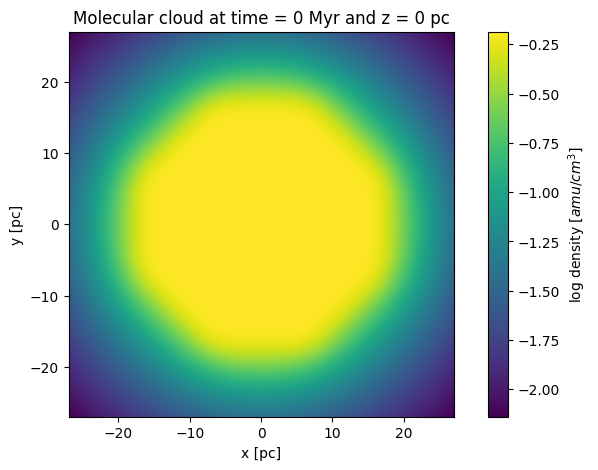

ready for evolution
Time 0.2 Myr
Time 0.4 Myr


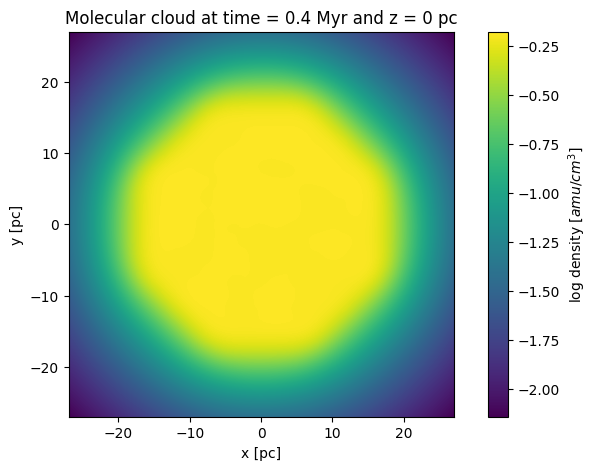

Average mass of a SPH particle 0.5181347150259056.


In [2]:
# initialise and evolve the MC particle set
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 1_000,
                                                         M_cloud = 500 | units.MSun,
                                                         R_cloud = 20 | units.pc,
                                                         seed = 1312)

particles_cloud, density_map = evolve_molecular_cloud(particles_cloud, 
                                         converter_cloud, 
                                         t_end = 0.4 | units.Myr, 
                                         dt = 0.2 | units.Myr, 
                                         seed = 1312)

In [3]:
def hydro_code(Code, dt, converter, particles, seed):
    '''
    This function contains the parameters we want to initialise the 
    hydro code with. (hard Coded)
    '''
    
    np.random.seed(seed)

    hydro = Code(converter)
    hydro.parameters.use_hydro_flag = True # Hydrodynamics flag. True means:
                            # SPH hydro included, False means: gravity only.
    hydro.parameters.gamma = 1 # gas polytropic index (1.6666667)
                        # (default value:1.6666667). In this case-> Ideal Gas   
    hydro.parameters.timestep = dt
    hydro.parameters.eps_is_h_flag = True # Default value
    hydro.parameters.radiation_flag = False # turns off radiatiative cooling/heat.
    hydro.parameters.isothermal_flag = True  # Isothermal flag. True means:
                # isothermal gas (requires integrate_entropy_flag == False)
    hydro.parameters.integrate_entropy_flag = False #True means: integrate
                                          # entropy, else: internal energy. 
    hydro.particles.add_particles(particles) # add the particles
   
    return hydro 

In [4]:
# def relative_orbital_velocity(mass, distance):
#     return (units.constants.G * mass / distance).sqrt()

In [5]:
# initialise the star particle set
star = Particles(1)
star.name = "star"
star.mass = 10 |units.MSun
star.radius = 5 | units.RSun
star.position = (-1.0, 0, 0) * (25 | units.pc)

# vorb = relative_orbital_velocity((star.mass.sum() + particles_cloud.mass.sum()), abs(star.position.sum()))
# star.velocity = (1.0, 0, 0) * (vorb.in_(units.kms))
star.velocity = (1.0, 0, 0) * (60 | units.kms)

converter_star = nbody_system.nbody_to_si(star.mass.sum(), 
                                   star.position.sum())

In [7]:
#start the hydro code for the gas
hydro_cloud = hydro_code(Code = Fi, dt = 0.1 | units.Myr,
                         converter = converter_cloud,
                         particles = particles_cloud,
                         seed = 1312)

# start the gravity code for the star
gravity_code = Bhtree(converter_star)
gravity_code.particles.add_particles(star)

channel = {"from_star": star.new_channel_to(gravity_code.particles),
            "to_star": gravity_code.particles.new_channel_to(star),
            "from_cloud": particles_cloud.new_channel_to(hydro_cloud.particles),
            "to_cloud": hydro_cloud.particles.new_channel_to(particles_cloud)}

In [8]:
gravhydrobridge = bridge.Bridge(use_threading = False)
gravhydrobridge.add_system(gravity_code, (hydro_cloud,) )
gravhydrobridge.add_system(hydro_cloud, (gravity_code,) )
gravhydrobridge.timestep = 0.1 | units.Myr

In [ ]:
t_end = 2 | units.Myr
model_time = 0 | units.Myr
dt = 0.1 | units.Myr

X_star = [] | units.pc
Y_star = [] | units.pc
Z_star = [] | units.pc

X_cloud = [] | units.pc
Y_cloud = [] | units.pc
Z_cloud = [] | units.pc

L = int(abs(star.position.sum().value_in(units.pc)))*1.2
N = 500

while model_time < t_end:

    model_time += dt
    gravhydrobridge.evolve_model(model_time)
    model_time = model_time.round(2)

    # update channels
    channel["to_star"].copy()
    channel["to_cloud"].copy()

    # save the star's position
    X_star.append(star.x)
    Y_star.append(star.y)
    Z_star.append(star.z)
    # save the cloud's position
    x_cloud = particles_cloud.center_of_mass()[0]
    X_cloud.append(x_cloud)
    y_cloud = particles_cloud.center_of_mass()[1]
    Y_cloud.append(y_cloud)
    z_cloud = particles_cloud.center_of_mass()[2]
    Z_cloud.append(z_cloud)

    print('Orbiter in progress at', model_time.value_in(units.Myr), ' Myr')

    plot_hydro_and_star(time = model_time, 
                        hydro = hydro_cloud,
                        star_particle = star,
                        L = L,
                        N = N, 
                        density_map_MC = density_map)

In [ ]:
gravity_code.stop()
hydro_cloud.stop()
gravhydrobridge.stop()

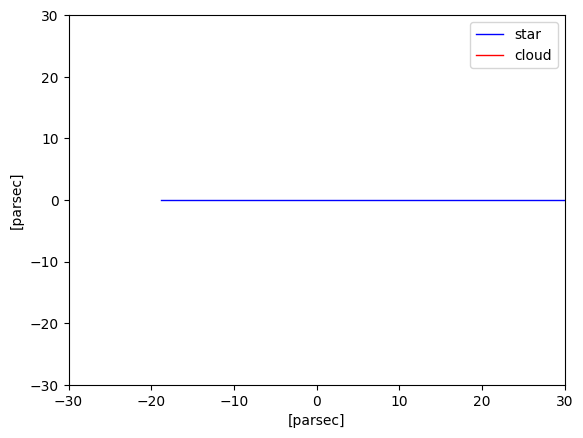

In [ ]:
from amuse.plot import plot, scatter
plot(X_star, Y_star, lw = 1, c = "blue", label = "star")
plot(X_cloud, Y_cloud, lw = 1, c = "red", label = "cloud")
plt.xlim([-30, 30])
plt.ylim([-30, 30])
plt.legend()
plt.show()